#### How to Use
There is an example usage section commented out at the bottom of the code. Please add the file path in the jpg/csv format and you can execute the code (# Update this to your image file ). Please make sure the source and sink pixel values are within the bounds of the image

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16384 rows, 65026 columns and 130050 nonzeros
Model fingerprint: 0x2599d7b9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-281, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 574 rows and 2784 columns
Presolve time: 0.08s
Presolved: 15810 rows, 62242 columns, 124412 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 3.107e+04
 Factor NZ  : 3.724e+05 (roughly 34 MB of memory)
 Factor Ops : 1.532e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         P

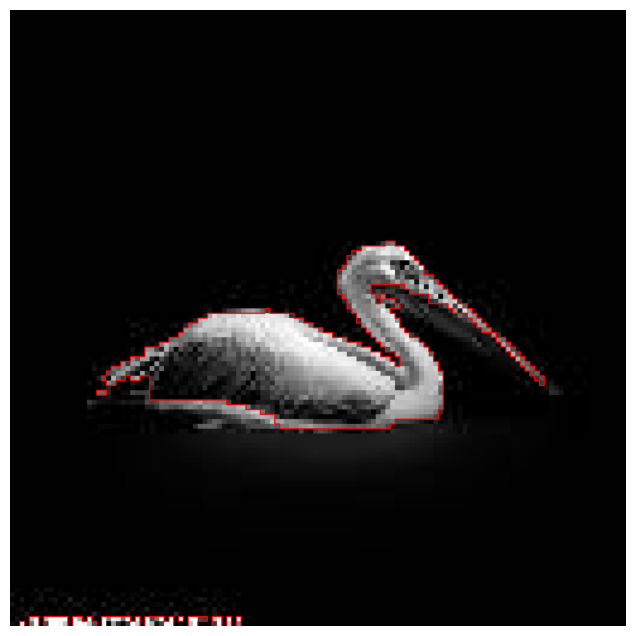

In [39]:
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to load image and handle jpg/csv format
def load_image(file):
    if file.endswith('.jpg'):
        try:
            image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if image is None:
                raise ValueError("Error loading the JPG file. It may be corrupted or not found.")
            normalized_image = image.astype(np.float32) / 255.0
            return normalized_image
        except Exception as e:
            raise ValueError(f"Error processing the JPG file: {e}")
    elif file.endswith('.csv'):
        try:
            return np.loadtxt(file, delimiter=',')
        except Exception as e:
            raise ValueError(f"Error loading the CSV file: {e}")
    else:
        raise ValueError("Unsupported file format. Please provide a .jpg or .csv file.")

# Calculate similarity between pixel intensities
def calculate_similarity(intensity1, intensity2, sigma):
    intensity_diff_squared = (intensity1 - intensity2) ** 2
    similarity = 100 * np.exp(-intensity_diff_squared / (2 * sigma ** 2))
    return similarity

# Build pixel network based on similarities
def build_network(image_data, sigma, source_pixel, sink_pixel):
    num_rows, num_cols = image_data.shape
    num_pixels = num_rows * num_cols
    network = {}  # Network to store edges and capacities
    source_node = num_pixels  # Index for source node
    sink_node = num_pixels + 1  # Index for sink node

    for row in range(num_rows):
        for col in range(num_cols):
            current_pixel = row * num_cols + col
            current_intensity = image_data[row, col]
            
            # Add right neighbor
            if col < num_cols - 1:
                neighbor_pixel = row * num_cols + (col + 1)
                neighbor_intensity = image_data[row, col + 1]
                similarity = calculate_similarity(current_intensity, neighbor_intensity, sigma)
                network[(current_pixel, neighbor_pixel)] = similarity
                network[(neighbor_pixel, current_pixel)] = similarity
            
            # Add below neighbor
            if row < num_rows - 1:
                neighbor_pixel = (row + 1) * num_cols + col
                neighbor_intensity = image_data[row + 1, col]
                similarity = calculate_similarity(current_intensity, neighbor_intensity, sigma)
                network[(current_pixel, neighbor_pixel)] = similarity
                network[(neighbor_pixel, current_pixel)] = similarity

    # Connect source and sink pixels
    max_intensity = max(network.values())
    source_node_pixel = source_pixel[0] * num_cols + source_pixel[1]
    sink_node_pixel = sink_pixel[0] * num_cols + sink_pixel[1]
    network[(source_node, source_node_pixel)] = max_intensity
    network[(sink_node_pixel, sink_node)] = max_intensity

    return network, source_node, sink_node

# Depth First Search to find accessible nodes
def dfs(residual_network, source_node):
    visited = set()
    stack = [source_node]
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            neighbors = [j for (i, j), capacity in residual_network.items() if i == node and capacity > 1e-5]
            stack.extend(neighbors)
    return visited

# Function to find the minimum cut from the flow network
def find_min_cut(network, flow, source_node):
    residual_network = {}
    for (i, j), capacity in network.items():
        flow_value = flow.get((i, j), 0)
        residual_capacity = capacity - flow_value
        if residual_capacity > 1e-5:
            residual_network[(i, j)] = residual_capacity
    
    accessible_nodes = dfs(residual_network, source_node)
    cut_edges = [(i, j) for (i, j) in network.keys() if i in accessible_nodes and j not in accessible_nodes]
    cut_value = sum(network[i, j] for i, j in cut_edges)
    
    return cut_edges, cut_value

# Main max-flow segmentation function
def maxflow_segmentation(file, source_pixel, sink_pixel, sigma):
    image_data = load_image(file)
    num_rows, num_cols = image_data.shape
    num_pixels = num_rows * num_cols
    
    network, source_node, sink_node = build_network(image_data, sigma, source_pixel, sink_pixel)
    
    mod = gp.Model()
    edges = list(network.keys())
    flow = mod.addVars(edges, lb=0, ub=network, name="flow")
    mod.setObjective(gp.quicksum(flow[i, sink_node] for i in range(num_pixels + 2) if (i, sink_node) in flow), gp.GRB.MAXIMIZE)

    for node in range(num_pixels + 2):
        if node == source_node or node == sink_node:
            continue
        inflow = gp.quicksum(flow[i, node] for i in range(num_pixels + 2) if (i, node) in flow)
        outflow = gp.quicksum(flow[node, j] for j in range(num_pixels + 2) if (node, j) in flow)
        mod.addConstr(inflow == outflow, name=f"flow_conservation_{node}")

    mod.optimize()
    
    if mod.Status != gp.GRB.OPTIMAL:
        print("Optimization unsuccessful")
        return

    flow_values = {(i, j): flow_var.X for (i, j), flow_var in flow.items()}
    cut_edges, cut_value = find_min_cut(network, flow_values, source_node)
    
    print(f"Min-Cut value (Max-Flow): {cut_value}")
    
    image_data_vis = (image_data * 255).astype(np.uint8)
    image_data_color = cv2.cvtColor(image_data_vis, cv2.COLOR_GRAY2BGR)
    scale_factor = 20
    enlarged_image = cv2.resize(image_data_color, (image_data_color.shape[1] * scale_factor, image_data_color.shape[0] * scale_factor), interpolation=cv2.INTER_NEAREST)
    
    for edge in cut_edges:
        i, j = edge
        if i < num_pixels and j < num_pixels:
            r1, c1 = divmod(i, num_cols)
            r2, c2 = divmod(j, num_cols)
            if abs(r1 - r2) + abs(c1 - c2) == 1:
                x1, y1 = c1 * scale_factor, r1 * scale_factor
                x2, y2 = c2 * scale_factor, r2 * scale_factor
                if r1 == r2:
                    x_border = min(x1, x2) + scale_factor
                    cv2.line(enlarged_image, (x_border, y1), (x_border, y1 + scale_factor - 1), (0, 0, 255), 4)
                elif c1 == c2:
                    y_border = min(y1, y2) + scale_factor
                    cv2.line(enlarged_image, (x1, y_border), (x1 + scale_factor - 1, y_border), (0, 0, 255), 4)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(enlarged_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage 
file = 'Pic3.jpg'  # Update this to your image file 
source_pixel = [0, 10]
sink_pixel = [75, 65] 
#Please make sure the source and sink pixel values are within the bounds of the image
sigma = 0.02771
#The pixel intensities are normalized so the above  sigma value can be used for all images
maxflow_segmentation(file, source_pixel, sink_pixel, sigma)
